# Clustering Customer

Since our customer data was not labelled and there is no feature that classifies them, we well move ahead and cluster them. The idea behind clustering is that, with cluster we might be able to identify atleast 4 categories of customers

- Bogo offer customers
- Discount offer customers
- Information offer customers
- No offer customers

In [1]:
import pandas as pd
import numpy as np
import math
import json
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import helpers
%matplotlib inline

In [2]:
def do_pca(data, n_components=None):
    '''
    DESCRIPTION:
        Transforms data using PCA to create n_components, and provides back the results of the
        transformation.
    INPUTS:
        data - the data you would like to transform
        n_components - int - the number of principal components to create
    OUTPUTS: 
        pca - the pca object created after fitting the data
        X_pca - the transformed X matrix with new number of components
    '''
    pca = PCA(n_components)
    X_pca = pd.DataFrame(pca.fit_transform(data))
    if n_components != None:
        X_pca.columns = ["pca_comp_" + str(i) for i in range(n_components)]
    X_pca.index = data.index
    
    return pca, X_pca

def scree_plot(pca, n_comp=None):
    '''
    DESCRIPTION:
        Creates a scree plot associated with the principal components 
    
    INPUTS:
        pca - the result of instantian of PCA in scikit learn    
    
    OUTPUTS:
        None
    '''
    if n_comp == None: # If no n_comp is provided, use all components
        num_components = len(pca.explained_variance_ratio_) #n_comp is provided
    elif n_comp < len(pca.explained_variance_ratio_):
        num_components = n_comp
    else: 
        #If the n_comp provided is greater than the total number of components,
        # then use all components
        num_components = len(pca.explained_variance_ratio_)
    indices = np.arange(num_components)
    values = pca.explained_variance_ratio_
    
    values = values[:num_components]
    
    plt.figure(figsize=(10,6))
    ax = plt.subplot(111)
    # Create array of cumulative variance explained for each n^th component
    cumulative_values = np.cumsum(values)
    # Plot bar chart of variance explained vs each component
    ax.bar(indices, values, color='tab:red')
    # Plot line chart of cumulative variance explained vs number of components
    ax.plot(indices, cumulative_values)
    
    # Plot the annotations only if there are less than 21 components, 
    # else it gets messy
    if num_components <= 20:
        for i in range(num_components):
            ax.annotate(r"%s%%" % ((str(values[i]*100)[:4])),\
                        (indices[i]+0.2, values[i]), va="bottom",\
                        ha="center", fontsize=12)
        
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
    
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

In [3]:
#read the data
all_data = pd.read_csv("all_cleaned_data.csv")


In [4]:
all_data

,gender,mem_year,mem_month,mem_day,total_spending,total_reward,total_offer_completed_bogo,total_offer_completed_discount,total_offer_completed_informational,average_offer_difficulty_bogo,...,total_web_offers,total_social_offers,total_mobile_offers,total_reward_earned,total_spent_on_offer,average_offer_difficulty,average_offer_duration,age,income,p_id
0,1,2017,2,12,20.40,5.0,0.0,2.0,0.0,0.000000,...,4.0,4.0,4.0,5.0,37.57,11.750000,8.500000,51.12317,56466.494845,6961
1,1,2018,7,12,14.30,0.0,0.0,0.0,0.0,5.000000,...,2.0,2.0,2.0,0.0,2.14,2.500000,5.000000,51.12317,70487.283331,3746
2,1,2017,8,4,4.65,0.0,0.0,0.0,0.0,0.000000,...,6.0,6.0,6.0,0.0,2.30,13.333333,7.833333,51.12317,60172.494172,10735
3,1,2017,9,25,0.00,0.0,0.0,0.0,0.0,10.000000,...,6.0,6.0,6.0,0.0,0.00,8.333333,7.666667,51.12317,59217.460317,9524
4,1,2017,10,2,0.24,0.0,0.0,0.0,0.0,8.333333,...,5.0,5.0,5.0,0.0,0.24,8.400000,6.600000,51.12317,58648.200566,6939
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16995,0,2018,6,4,20.03,0.0,0.0,0.0,0.0,10.000000,...,3.0,3.0,3.0,0.0,6.76,5.666667,5.000000,45.00000,54000.000000,7264
16996,1,2018,7,13,25.97,5.0,1.0,0.0,0.0,5.000000,...,3.0,3.0,3.0,5.0,6.46,1.666667,4.666667,61.00000,72000.000000,2887
16997,1,2017,1,26,39.74,0.0,0.0,0.0,0.0,0.000000,...,3.0,3.0,3.0,0.0,30.11,6.666667,5.666667,49.00000,73000.000000,105
16998,0,2016,3,7,189.67,25.0,1.0,0.0,0.0,10.000000,...,1.0,1.0,1.0,10.0,57.50,10.000000,5.000000,83.00000,50000.000000,10567


In [5]:
all_data = all_data.drop('p_id', axis='columns')

In [6]:
ss = StandardScaler()
collist = all_data.columns.tolist()
all_data_scaled =all_data.copy(deep=True)
all_data_scaled[collist] = ss.fit_transform(all_data_scaled)
all_data_scaled


,gender,mem_year,mem_month,mem_day,total_spending,total_reward,total_offer_completed_bogo,total_offer_completed_discount,total_offer_completed_informational,average_offer_difficulty_bogo,...,total_email_offers,total_web_offers,total_social_offers,total_mobile_offers,total_reward_earned,total_spent_on_offer,average_offer_difficulty,average_offer_duration,age,income
0,0.696445,0.309955,-1.343142,-0.442293,-0.667401,-0.507070,-0.790865,0.877639,0.0,-1.961312,...,-0.224306,-0.224306,-0.224306,-0.224306,-0.401334,-0.453873,1.407177,1.697710,-0.173620,-0.405578
1,0.696445,1.159148,0.090757,-0.442293,-0.715844,-1.048023,-0.790865,-0.851498,0.0,-0.432732,...,-1.559226,-1.559226,-1.559226,-1.559226,-0.971944,-0.665806,-1.707758,-1.187647,-0.173620,0.285036
2,0.696445,0.309955,0.377537,-1.353960,-0.792481,-1.048023,-0.790865,-0.851498,0.0,-1.961312,...,1.110615,1.110615,1.110615,1.110615,-0.971944,-0.664849,1.940364,1.148118,-0.173620,-0.223034
3,0.696445,0.309955,0.664317,1.039167,-0.829410,-1.048023,-0.790865,-0.851498,0.0,1.095849,...,1.110615,1.110615,1.110615,1.110615,-0.971944,-0.678607,0.256616,1.010720,-0.173620,-0.270075
4,0.696445,0.309955,0.951097,-1.581877,-0.827504,-1.048023,-0.790865,-0.851498,0.0,0.586322,...,0.443154,0.443154,0.443154,0.443154,-0.971944,-0.677172,0.279065,0.131374,-0.173620,-0.298115
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16995,-1.293398,1.159148,-0.196022,-1.353960,-0.670339,-1.048023,-0.790865,-0.851498,0.0,1.095849,...,-0.891766,-0.891766,-0.891766,-0.891766,-0.971944,-0.638171,-0.641384,-1.187647,-0.549636,-0.527069
16996,0.696445,1.159148,0.090757,-0.328334,-0.623166,-0.507070,0.212846,-0.851498,0.0,-0.432732,...,-0.891766,-0.891766,-0.891766,-0.891766,-0.401334,-0.639965,-1.988383,-1.462443,0.432902,0.359547
16997,0.696445,0.309955,-1.629921,1.153125,-0.513810,-1.048023,-0.790865,-0.851498,0.0,-1.961312,...,-0.891766,-0.891766,-0.891766,-0.891766,-0.971944,-0.498497,-0.304634,-0.638055,-0.304001,0.408804
16998,-1.293398,-0.539237,-1.056362,-1.012085,0.676877,1.656742,0.212846,-0.851498,0.0,1.095849,...,-2.226687,-2.226687,-2.226687,-2.226687,0.169277,-0.334657,0.817865,-1.187647,1.783892,-0.724095


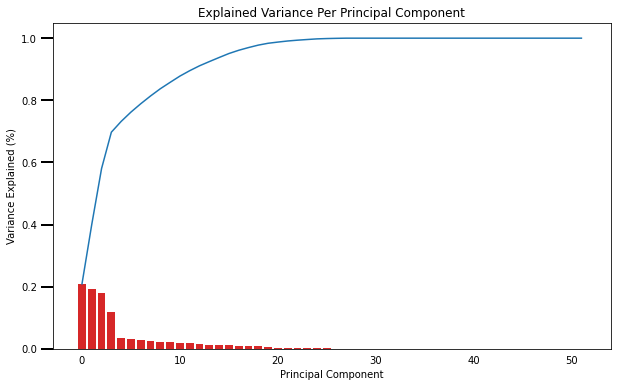

In [7]:
pca, X_train_pca = do_pca(all_data_scaled)
scree_plot(pca)

In [8]:
from sklearn.decomposition import PCA
n_components = 25
pca = PCA(n_components)
X_pca = pca.fit_transform(all_data_scaled)

In [9]:
def component_weight(index):
    weights = pd.DataFrame(pca.components_, columns=all_data_scaled.columns.values)
    return pd.DataFrame(weights.loc[index]).sort_values(index, ascending = False)

In [10]:
component_weight(0).head()

,0
total_social_offers_discount,0.287895
total_web_offers_discount,0.287895
total_offer_received_discount,0.287895
total_mobile_offers_discount,0.287895
total_email_offers_discount,0.287895


In [11]:
component_weight(1).head()

,1
total_email_offers,0.260933
total_mobile_offers,0.260933
total_offer_received,0.260933
total_social_offers,0.260933
total_web_offers,0.260933


In [12]:
component_weight(2).head()

,2
total_social_offers_informational,0.289905
total_web_offers_informational,0.289905
total_offer_received_informational,0.289905
total_mobile_offers_informational,0.289905
total_email_offers_informational,0.289905


In [15]:
from sklearn.cluster import KMeans
def get_kmeans_score(data, center):
    '''
    returns the kmeans score regarding SSE for points to centers
    INPUT:
        data - the dataset you want to fit kmeans to
        center - the number of centers you want (the k value)
    OUTPUT:
        score - the SSE score for the kmeans model fit to the data
    '''
    #instantiate kmeans
    kmeans = KMeans(n_clusters=center)

    # Then fit the model to your data using the fit method
    model = kmeans.fit(data)
    
    # Obtain a score related to the model fit
    score = np.abs(model.score(data))
    
    return score


In [16]:
from collections import OrderedDict

scores = OrderedDict({})


In [17]:
for center in range(1, 20):
    if center not in scores.keys():
        scores[center]= get_kmeans_score(X_pca, center)

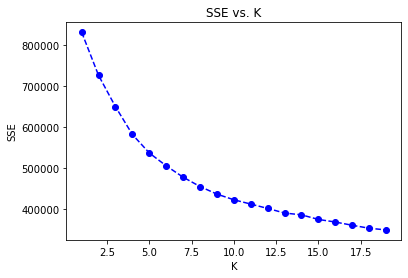

In [18]:
scores = OrderedDict(sorted(scores.items(), key=lambda t: t[0]))
plt.plot(scores.keys(), scores.values(), linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K');

# Clustering Discussion

The above graph shows that there are actually 6 cluster based on elbow method. We can now dig into the details of these clusters to see what exactly these clusters mean

In [19]:
kmeans = KMeans(n_clusters=6)

    # Then fit the model to your data using the fit method
model = kmeans.fit(X_pca)
general_prediction = model.predict(X_pca)


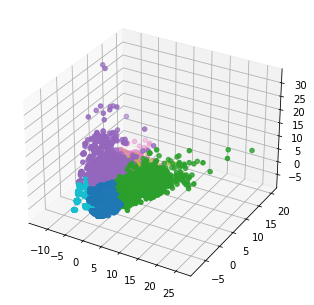

In [20]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure();
ax = Axes3D(fig)
ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=general_prediction, cmap='tab10');

In [21]:
general_prediction

array([1, 5, 1, ..., 0, 5, 0], dtype=int32)

In [22]:
all_data['cluster'] = general_prediction

In [23]:
all_data.columns

Index(['gender', 'mem_year', 'mem_month', 'mem_day', 'total_spending',
       'total_reward', 'total_offer_completed_bogo',
       'total_offer_completed_discount', 'total_offer_completed_informational',
       'average_offer_difficulty_bogo', 'average_offer_difficulty_discount',
       'average_offer_difficulty_informational', 'average_offer_duration_bogo',
       'average_offer_duration_discount',
       'average_offer_duration_informational', 'total_email_offers_bogo',
       'total_email_offers_discount', 'total_email_offers_informational',
       'total_mobile_offers_bogo', 'total_mobile_offers_discount',
       'total_mobile_offers_informational', 'total_offer_received_bogo',
       'total_offer_received_discount', 'total_offer_received_informational',
       'total_reward_earned_bogo', 'total_reward_earned_discount',
       'total_reward_earned_informational', 'total_social_offers_bogo',
       'total_social_offers_discount', 'total_social_offers_informational',
       'total_sp

In [24]:
clusters = all_data.groupby('cluster').agg({
    "total_offer_completed_bogo": 'sum',
    "total_offer_viewed_informational": 'sum',
    "total_offer_received_informational": 'sum',
    "total_offer_completed_discount": 'sum',
    'total_spent_on_offer_informational': 'sum',
    "total_offer_completed": 'sum',
    "total_offer_received": 'sum',
    "total_spent_on_offer": 'sum',
    "total_spending": 'sum',
})
clusters

,total_offer_completed_bogo,total_offer_viewed_informational,total_offer_received_informational,total_offer_completed_discount,total_spent_on_offer_informational,total_offer_completed,total_offer_received,total_spent_on_offer,total_spending
cluster,,,,,,,,,
0,2633.0,2966.0,4477.0,5551.0,47475.74,8184.0,22009.0,431303.99,509208.97
1,1095.0,903.0,1241.0,5880.0,20855.24,6975.0,12039.0,456196.12,296030.09
2,1253.0,6018.0,6717.0,1503.0,99918.43,2756.0,11949.0,232225.46,210278.68
3,449.0,767.0,1151.0,621.0,3787.86,1070.0,11499.0,64708.28,52390.29
4,6483.0,1147.0,1512.0,3188.0,38792.18,9671.0,11983.0,656676.26,556302.06
5,1482.0,1037.0,1480.0,0.0,20315.51,1482.0,4234.0,87477.65,151241.88


In [27]:
clusters['percentage_completed_bogo_offers'] = 100*clusters['total_offer_completed_bogo']/clusters['total_offer_completed']
clusters['percentage_completed_discount_offers'] = 100*clusters['total_offer_completed_discount']/clusters['total_offer_completed']
clusters['percentage_viewed_informational_offers'] = 100*clusters['total_offer_viewed_informational']/clusters['total_offer_received']
clusters['percentage_spent_on_informational_offers'] = 100*clusters['total_spent_on_offer_informational']/clusters['total_spent_on_offer']
clusters['percentage_offer_completed'] = 100*clusters['total_offer_completed']/(clusters['total_offer_received']-clusters['total_offer_viewed_informational'])
clusters['precentage_share_of_sales'] = 100*clusters['total_spending']/clusters['total_spending'].sum()
clusters['precentage_share_of_offers'] = 100*clusters['total_offer_received']/clusters['total_offer_received'].sum()
clusters

,total_offer_completed_bogo,total_offer_viewed_informational,total_offer_received_informational,total_offer_completed_discount,total_spent_on_offer_informational,total_offer_completed,total_offer_received,total_spent_on_offer,total_spending,percentage_completed_bogo_offers,percentage_completed_discount_offers,percentage_viewed_informational_offers,percentage_spent_on_informational_offers,percentage_offer_completed,precentage_share_of_sales,precentage_share_of_offers
cluster,,,,,,,,,,,,,,,,
0,2633.0,2966.0,4477.0,5551.0,47475.74,8184.0,22009.0,431303.99,509208.97,32.172532,67.827468,13.476305,11.007489,42.976422,28.680526,29.857691
1,1095.0,903.0,1241.0,5880.0,20855.24,6975.0,12039.0,456196.12,296030.09,15.698925,84.301075,7.500623,4.571551,62.634698,16.673506,16.332262
2,1253.0,6018.0,6717.0,1503.0,99918.43,2756.0,11949.0,232225.46,210278.68,45.464441,54.535559,50.364047,43.026475,46.467712,11.843670,16.210166
3,449.0,767.0,1151.0,621.0,3787.86,1070.0,11499.0,64708.28,52390.29,41.962617,58.037383,6.670145,5.853749,9.970183,2.950814,15.599691
4,6483.0,1147.0,1512.0,3188.0,38792.18,9671.0,11983.0,656676.26,556302.06,67.035467,32.964533,9.571894,5.907352,89.248800,31.332983,16.256291
5,1482.0,1037.0,1480.0,0.0,20315.51,1482.0,4234.0,87477.65,151241.88,100.000000,0.000000,24.492206,23.223658,46.355959,8.518500,5.743899


In [28]:
def assign_offer_to_clusters(row):
    if (row['total_spent_on_offer']<row['total_spending']):
        return 'Sleeping Dog'
    if (row['percentage_completed_bogo_offers'] > 50 and
        row['percentage_completed_bogo_offers'] > row['percentage_completed_discount_offers'] 
        and row['percentage_completed_bogo_offers'] > row['percentage_viewed_informational_offers']):
        return "Bogo"
    if (row['percentage_completed_discount_offers'] > 50 and
        row['percentage_completed_discount_offers'] > row['percentage_completed_bogo_offers'] 
        and row['percentage_completed_discount_offers'] > row['percentage_viewed_informational_offers']):
        return "Discount"
    if (row['percentage_spent_on_informational_offers'] > 30 and
        row['percentage_viewed_informational_offers'] > row['percentage_completed_bogo_offers'] 
        and row['percentage_viewed_informational_offers'] > row['percentage_completed_discount_offers']):
        return "Information"
    return 'None'

In [31]:
clusters['offer_type']=clusters.apply(assign_offer_to_clusters, axis=1)
clusters


,total_offer_completed_bogo,total_offer_viewed_informational,total_offer_received_informational,total_offer_completed_discount,total_spent_on_offer_informational,total_offer_completed,total_offer_received,total_spent_on_offer,total_spending,percentage_completed_bogo_offers,percentage_completed_discount_offers,percentage_viewed_informational_offers,percentage_spent_on_informational_offers,percentage_offer_completed,precentage_share_of_sales,precentage_share_of_offers,offer_type
cluster,,,,,,,,,,,,,,,,,
0,2633.0,2966.0,4477.0,5551.0,47475.74,8184.0,22009.0,431303.99,509208.97,32.172532,67.827468,13.476305,11.007489,42.976422,28.680526,29.857691,Sleeping Dog
1,1095.0,903.0,1241.0,5880.0,20855.24,6975.0,12039.0,456196.12,296030.09,15.698925,84.301075,7.500623,4.571551,62.634698,16.673506,16.332262,Discount
2,1253.0,6018.0,6717.0,1503.0,99918.43,2756.0,11949.0,232225.46,210278.68,45.464441,54.535559,50.364047,43.026475,46.467712,11.843670,16.210166,Discount
3,449.0,767.0,1151.0,621.0,3787.86,1070.0,11499.0,64708.28,52390.29,41.962617,58.037383,6.670145,5.853749,9.970183,2.950814,15.599691,Discount
4,6483.0,1147.0,1512.0,3188.0,38792.18,9671.0,11983.0,656676.26,556302.06,67.035467,32.964533,9.571894,5.907352,89.248800,31.332983,16.256291,Bogo
5,1482.0,1037.0,1480.0,0.0,20315.51,1482.0,4234.0,87477.65,151241.88,100.000000,0.000000,24.492206,23.223658,46.355959,8.518500,5.743899,Sleeping Dog


In [32]:
clusters['offer_type']


cluster
0    Sleeping Dog
1        Discount
2        Discount
3        Discount
4            Bogo
5    Sleeping Dog
Name: offer_type, dtype: object

## Conclusion

With the above clustering data we can identify which group is more likely to try which offer


We have used following rules to assign offer type to clusters
- Group of customer whose spending is less during offers and more outside offers [Sleeping Dogs Group]
- Group who has completed more than 50% Discount offer and has completed more discount offer than any other type than they are [Discount Group]
- Group who has completed more than 50% Bogo offer and has completed more bogo offer than any other type than they are [Bogo Group]
- Group who has spent more than 30% during Informational offer and has viewed more isformational offer than any other type than they are [Informational Group]

### Some other finding

<AxesSubplot:xlabel='cluster'>

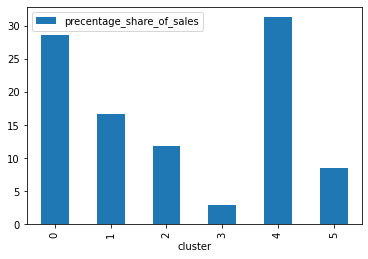

In [33]:
clusters.plot(y='precentage_share_of_sales', kind="bar", use_index=True)

Any customer which belongs to cluster `3` is likely to respond to `bogo` offers compared to other offers

*Cluster 3 has the greatest share of sales*

<AxesSubplot:xlabel='cluster'>

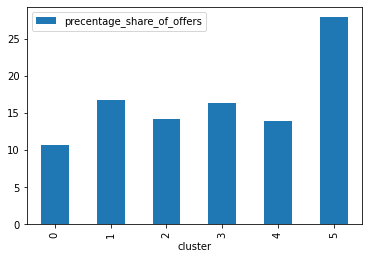

In [224]:
clusters.plot(y='precentage_share_of_offers', kind="bar", use_index=True)

*on the otherhand cluster 5 has received most offer*